<a href="https://colab.research.google.com/github/shauryasachdev/Vizuara_CV/blob/main/HPT_Sweeo_Deep_NN_for_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ────────────────────────────────────────────────────────────────
# Standard library & OS / file handling
import os
import pathlib
import random
import glob

# Image & display utilities
from PIL import Image
import IPython.display as display
import matplotlib.pyplot as plt   # usually preferred over pylab

# Data science & numerics
import numpy as np

# Weights & Biases ────────────────────────────────────────────────
import wandb
from wandb.integration.keras import WandbMetricsLogger   # batch-level logging

# TensorFlow / Keras ──────────────────────────────────────────────
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D,
    Softmax,
    Input,               # recommended for explicit input shape
)
import tensorflow_hub as hub

In [2]:
from google.colab import auth
auth.authenticate_user()


PROJECT = "plated-shelter-464511-f9" # REPLACE WITH YOUR PROJECT ID
BUCKET = "bucket_ml_ss" # REPLACE WITH YOUR BUCKET NAME
REGION = "asia" # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

# do not change these
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["TFVERSION"] = "2.19"  # Tensorflow version

In [3]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


In [4]:
sweep_config = {

    'method' : 'grid',
    'metric' : {
        'name': 'valid_accuray',
        'goal': 'maximize'
              },

    'parameters': {
        'batch_size': {'values': [8,16]},
        'learning_rate': {'values': [0.001, 0.0001]},
    'hidden_nodes' : {'values' : [128,64]},
    'img_size' : {'values' : [16,224]},
     'epochs' :{'values' : [5,10]}
                  }

    }

sweep_id = wandb.sweep(sweep_config, project="5-flowers-v2")

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Create sweep with ID: f5jvphay
Sweep URL: https://wandb.ai/shauryasachdev/5-flowers-v2/sweeps/f5jvphay


In [5]:
from google.colab import drive
drive.mount('/content/drive')  # Mounts Drive at /content/drive/

# Set your desired Drive path (creates folder if it doesn't exist)
drive_path = '/content/drive/MyDrive/Colab Notebooks/flower_dataset/'

# Download and extract directly to the Drive path
# archive = tf.keras.utils.get_file(
#    'flower_photos.tgz',
#    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
#    cache_dir=drive_path,  # Saves here instead of local cache
#    extract=True
#)

# Your exact path as Path object
data_dir = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/flower_dataset/datasets/flower_photos_extracted/flower_photos')

# Verify
image_count = len(list(data_dir.glob('*/*.jpg')))
print("There are", image_count, "images.")  # Should be 3670

CLASS_NAMES = np.array(
    [item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt" and item.is_dir()]
)
print("These are the available classes:", CLASS_NAMES)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
There are 3670 images.
These are the available classes: ['dandelion' 'daisy' 'tulips' 'roses' 'sunflowers']


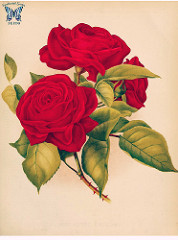

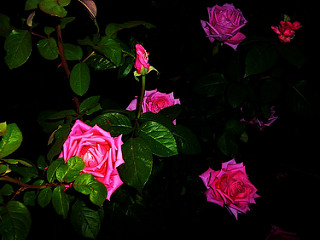

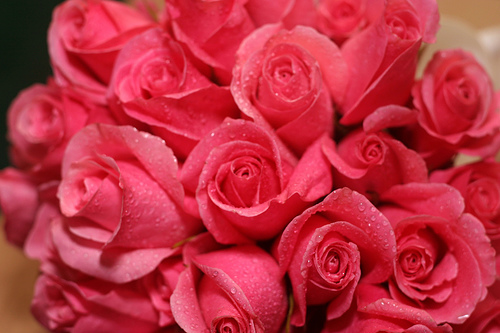

In [6]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

In [7]:
# Your Drive path to the flower_photos folder with class subdirs
data_dir = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/flower_dataset/datasets/flower_photos_extracted/flower_photos')

# Collect all image paths and labels from Drive (local paths)
all_images = []
for class_name in CLASS_NAMES:
    class_dir = data_dir / class_name
    images = glob.glob(str(class_dir / '*.jpg'))
    for img in images:
        all_images.append(f"{img},{class_name}")

# Shuffle and split into train/eval (80/20)
random.shuffle(all_images)
num_total = len(all_images)
num_train = int(0.8 * num_total)
train_lines = all_images[:num_train]
eval_lines = all_images[num_train:]

# Write CSVs to Drive (using data_dir as base)
train_csv_path = os.path.join(str(data_dir), 'train_set.csv')
eval_csv_path = os.path.join(str(data_dir), 'eval_set.csv')

with open(train_csv_path, 'w') as f:
    f.write('\n'.join(train_lines))
with open(eval_csv_path, 'w') as f:
    f.write('\n'.join(eval_lines))

# Verify: Print first 5 lines of train CSV using shell (with quoted path to avoid syntax errors)
!head -5 "{train_csv_path}"

/content/drive/MyDrive/Colab Notebooks/flower_dataset/datasets/flower_photos_extracted/flower_photos/tulips/8511683706_4173683d45_m.jpg,tulips
/content/drive/MyDrive/Colab Notebooks/flower_dataset/datasets/flower_photos_extracted/flower_photos/tulips/113960470_38fab8f2fb_m.jpg,tulips
/content/drive/MyDrive/Colab Notebooks/flower_dataset/datasets/flower_photos_extracted/flower_photos/daisy/5547758_eea9edfd54_n.jpg,daisy
/content/drive/MyDrive/Colab Notebooks/flower_dataset/datasets/flower_photos_extracted/flower_photos/daisy/2599662355_7782218c83.jpg,daisy
/content/drive/MyDrive/Colab Notebooks/flower_dataset/datasets/flower_photos_extracted/flower_photos/roses/14408977935_a397e796b8_m.jpg,roses


In [8]:
def train():
  with wandb.init() as run:
    config = wandb.config

    Img_Height = config.img_size
    Img_Width = config.img_size
    Img_Channels = 3


    def read_and_decode(filename, resize_dims):
      # Read the raw file
      img_bytes = tf.io.read_file(filename)
      # Decode the image data
      img = tf.image.decode_jpeg(img_bytes, channels=Img_Channels)
      # Convert the pixel values to float in [0,1]
      img = tf.image.convert_image_dtype(img, tf.float32)
      # Resize the image to desired dimensions
      img = tf.image.resize(img, resize_dims)
      return img

    def parse_csvline(csv_line):
      # record_defaults specify the data types for each column
      record_default = ["", ""]
      filename, label_string = tf.io.decode_csv(csv_line, record_default)

      # Load the image
      img = read_and_decode(filename, [Img_Height, Img_Width])

      # Conver label string to integer based on the Class_Names index
      label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
      return img, label

    train_dataset = (
      tf.data.TextLineDataset(train_csv_path)
      .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(config.batch_size)
      .prefetch(tf.data.AUTOTUNE)
      )

    eval_dataset = (
      tf.data.TextLineDataset(eval_csv_path)
      .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(config.batch_size)
      .prefetch(tf.data.AUTOTUNE)
      )

    model = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=(Img_Height, Img_Width, Img_Channels)),
      tf.keras.layers.Dense(config.hidden_nodes, activation = 'relu'),
      tf.keras.layers.Dense(len(CLASS_NAMES), activation = 'softmax')
    ])

    model.compile(
      optimizer =tf.keras.optimizers.Adam(config.learning_rate),
      loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
      metrics=["accuracy"]
    )

    callbacks = []

    model.fit(
      train_dataset,
      validation_data = eval_dataset,
      epochs = config.epochs,
      callbacks = [WandbMetricsLogger(log_freq=5)],
  )

In [9]:
wandb.agent(sweep_id, function=train)

wandb: Agent Starting Run: s9rs0v86 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 5
wandb: 	hidden_nodes: 128
wandb: 	img_size: 16
wandb: 	learning_rate: 0.001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.
wandb: Currently logged in as: shauryasachdev to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


    367/Unknown 381s 1s/step - accuracy: 0.3434 - loss: 1.5569

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


367/367 ━━━━━━━━━━━━━━━━━━━━ 514s 1s/step - accuracy: 0.3435 - loss: 1.5566 - val_accuracy: 0.4550 - val_loss: 1.2586
Epoch 2/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.4569 - loss: 1.2772 - val_accuracy: 0.4605 - val_loss: 1.2101
Epoch 3/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.4938 - loss: 1.2164 - val_accuracy: 0.4632 - val_loss: 1.2060
Epoch 4/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.5223 - loss: 1.1713 - val_accuracy: 0.4728 - val_loss: 1.1995
Epoch 5/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.5497 - loss: 1.1212 - val_accuracy: 0.4850 - val_loss: 1.1866


batch/accuracy,▁▁▁▂▂▂▂▂▃▅▅▅▅▅▅▅▅▆▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█████
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▅▅▅▅▄▃▃▃▃▃▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▄▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▃▂▁
epoch/val_accuracy,▁▂▃▅█
epoch/val_loss,█▃▃▂▁
batch/accuracy,0.54611


wandb: Agent Starting Run: p1ph11e2 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 5
wandb: 	hidden_nodes: 128
wandb: 	img_size: 16
wandb: 	learning_rate: 0.0001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.2876 - loss: 1.5572 - val_accuracy: 0.3924 - val_loss: 1.3753
Epoch 2/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.4157 - loss: 1.3556 - val_accuracy: 0.4305 - val_loss: 1.3068
Epoch 3/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.4526 - loss: 1.2908 - val_accuracy: 0.4373 - val_loss: 1.2706
Epoch 4/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.4776 - loss: 1.2489 - val_accuracy: 0.4455 - val_loss: 1.2480
Epoch 5/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.4966 - loss: 1.2180 - val_accuracy: 0.4496 - val_loss: 1.2324


batch/accuracy,▁▂▂▂▄▄▄▄▄▄▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████
batch/batch_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▇▇▇▇▇█████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▆▆▆▅▅▃▄▃▃▃▃▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁
epoch/accuracy,▁▄▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▃▂▁
epoch/val_accuracy,▁▆▇██
epoch/val_loss,█▅▃▂▁
batch/accuracy,0.51093


wandb: Agent Starting Run: gebq8jvl with config:
wandb: 	batch_size: 8
wandb: 	epochs: 5
wandb: 	hidden_nodes: 128
wandb: 	img_size: 224
wandb: 	learning_rate: 0.001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 102s 276ms/step - accuracy: 0.2800 - loss: 24.2557 - val_accuracy: 0.3747 - val_loss: 8.5426
Epoch 2/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 201s 438ms/step - accuracy: 0.2819 - loss: 3.0447 - val_accuracy: 0.2452 - val_loss: 1.6000
Epoch 3/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 112s 304ms/step - accuracy: 0.2594 - loss: 1.5798 - val_accuracy: 0.2548 - val_loss: 1.6104
Epoch 4/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 120s 326ms/step - accuracy: 0.2801 - loss: 1.5678 - val_accuracy: 0.2480 - val_loss: 1.5965
Epoch 5/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 121s 329ms/step - accuracy: 0.2759 - loss: 1.5646 - val_accuracy: 0.2493 - val_loss: 1.6004


batch/accuracy,▁▂▃▃▄▄▄▄▄▄▅▇█▅▃▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▃▂▃▃▃▃▃▃▃
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▅▅▅▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,█▁▁▃▂
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/val_accuracy,█▁▂▁▁
epoch/val_loss,█▁▁▁▁
batch/accuracy,0.27015


wandb: Agent Starting Run: 1swh10gf with config:
wandb: 	batch_size: 8
wandb: 	epochs: 5
wandb: 	hidden_nodes: 128
wandb: 	img_size: 224
wandb: 	learning_rate: 0.0001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 114s 309ms/step - accuracy: 0.3114 - loss: 2.6997 - val_accuracy: 0.4714 - val_loss: 1.2935
Epoch 2/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 148s 323ms/step - accuracy: 0.4394 - loss: 1.4545 - val_accuracy: 0.4537 - val_loss: 1.3745
Epoch 3/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 114s 311ms/step - accuracy: 0.4597 - loss: 1.3652 - val_accuracy: 0.4183 - val_loss: 1.6207
Epoch 4/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 115s 313ms/step - accuracy: 0.4620 - loss: 1.3086 - val_accuracy: 0.4373 - val_loss: 1.4495
Epoch 5/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 114s 310ms/step - accuracy: 0.4606 - loss: 1.2653 - val_accuracy: 0.4237 - val_loss: 1.3512


batch/accuracy,▁▁▃▃▃▄▄▄▄▄▄▄▄▆▆▆▇▇▇▇▅█▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇█
batch/batch_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▅▅▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▆▇▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▂▁
epoch/val_accuracy,█▆▁▄▂
epoch/val_loss,▁▃█▄▂
batch/accuracy,0.486


wandb: Agent Starting Run: okd833h7 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 5
wandb: 	hidden_nodes: 64
wandb: 	img_size: 16
wandb: 	learning_rate: 0.001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Epoch 1/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.3488 - loss: 1.5299 - val_accuracy: 0.4441 - val_loss: 1.2695
Epoch 2/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.4460 - loss: 1.2875 - val_accuracy: 0.4332 - val_loss: 1.2664
Epoch 3/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4606 - loss: 1.2407 - val_accuracy: 0.4687 - val_loss: 1.2106
Epoch 4/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.5009 - loss: 1.1822 - val_accuracy: 0.4659 - val_loss: 1.2115
Epoch 5/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.5187 - loss: 1.1479 - val_accuracy: 0.4714 - val_loss: 1.1990


batch/accuracy,▁▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▅▅▆▆▆▇▆▆▆▆▆▆▆▇▇▇▇▇▇████
batch/batch_step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,██▇▇▇▆▆▆▆▆▅▅▁▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▃▃▂▂▂▂▂▂▂
epoch/accuracy,▁▄▅▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▃▂▁
epoch/val_accuracy,▃▁▇▇█
epoch/val_loss,██▂▂▁
batch/accuracy,0.53586


wandb: Agent Starting Run: sa6esl6n with config:
wandb: 	batch_size: 8
wandb: 	epochs: 5
wandb: 	hidden_nodes: 64
wandb: 	img_size: 16
wandb: 	learning_rate: 0.0001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.2816 - loss: 1.5661 - val_accuracy: 0.3488 - val_loss: 1.4358
Epoch 2/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.4110 - loss: 1.3952 - val_accuracy: 0.3787 - val_loss: 1.3489
Epoch 3/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4390 - loss: 1.3240 - val_accuracy: 0.4114 - val_loss: 1.3041
Epoch 4/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4564 - loss: 1.2827 - val_accuracy: 0.4305 - val_loss: 1.2754
Epoch 5/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4774 - loss: 1.2515 - val_accuracy: 0.4469 - val_loss: 1.2553


batch/accuracy,▁▁▂▂▃▃▃▃▃▂▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,███▇▇▇▇▇▆▄▄▄▄▄▄▄▄▃▂▂▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▅▃▂▁
epoch/val_accuracy,▁▃▅▇█
epoch/val_loss,█▅▃▂▁
batch/accuracy,0.486


wandb: Agent Starting Run: flpwqygi with config:
wandb: 	batch_size: 8
wandb: 	epochs: 5
wandb: 	hidden_nodes: 64
wandb: 	img_size: 224
wandb: 	learning_rate: 0.001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 111s 188ms/step - accuracy: 0.2042 - loss: 7.6638 - val_accuracy: 0.2411 - val_loss: 1.6065
Epoch 2/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 78s 176ms/step - accuracy: 0.2479 - loss: 1.6032 - val_accuracy: 0.2411 - val_loss: 1.6036
Epoch 3/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 72s 195ms/step - accuracy: 0.2480 - loss: 1.5995 - val_accuracy: 0.2411 - val_loss: 1.6031
Epoch 4/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 70s 190ms/step - accuracy: 0.2482 - loss: 1.5988 - val_accuracy: 0.2411 - val_loss: 1.6029
Epoch 5/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 71s 192ms/step - accuracy: 0.2482 - loss: 1.5982 - val_accuracy: 0.2411 - val_loss: 1.6030


batch/accuracy,▁▃▄▃▃▃▄▄▇█▆▆▆▆▆▆▆▆▆▆▆▆▆▇▅▆▆▆▆▆▆▆▆▅▅▆▆▆▆▆
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▄▄▄▄▄▄▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁████
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/val_accuracy,▁▁▁▁▁
epoch/val_loss,█▂▁▁▁
batch/accuracy,0.2459


wandb: Agent Starting Run: 0jyrj0nk with config:
wandb: 	batch_size: 8
wandb: 	epochs: 5
wandb: 	hidden_nodes: 64
wandb: 	img_size: 224
wandb: 	learning_rate: 0.0001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 72s 196ms/step - accuracy: 0.2320 - loss: 2.0842 - val_accuracy: 0.2411 - val_loss: 1.6087
Epoch 2/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 83s 198ms/step - accuracy: 0.2483 - loss: 1.6084 - val_accuracy: 0.2398 - val_loss: 1.6119
Epoch 3/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 70s 190ms/step - accuracy: 0.2528 - loss: 1.6296 - val_accuracy: 0.2411 - val_loss: 1.6074
Epoch 4/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 69s 188ms/step - accuracy: 0.2482 - loss: 1.6064 - val_accuracy: 0.2411 - val_loss: 1.6068
Epoch 5/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 142s 386ms/step - accuracy: 0.2482 - loss: 1.6056 - val_accuracy: 0.2411 - val_loss: 1.6063


batch/accuracy,▁▃▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄█▅▅▄▄▄▄▄▄▅▄▄▄▄▄▄▃▄▄▄▄
batch/batch_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▇█▇▇
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/val_accuracy,█▁███
epoch/val_loss,▄█▂▂▁
batch/accuracy,0.2459


wandb: Agent Starting Run: 4flunh0x with config:
wandb: 	batch_size: 8
wandb: 	epochs: 10
wandb: 	hidden_nodes: 128
wandb: 	img_size: 16
wandb: 	learning_rate: 0.001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.3289 - loss: 1.5435 - val_accuracy: 0.4469 - val_loss: 1.2666
Epoch 2/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.4369 - loss: 1.2918 - val_accuracy: 0.4659 - val_loss: 1.2228
Epoch 3/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.4732 - loss: 1.2259 - val_accuracy: 0.4741 - val_loss: 1.2008
Epoch 4/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.4991 - loss: 1.1707 - val_accuracy: 0.4809 - val_loss: 1.1896
Epoch 5/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.5396 - loss: 1.1186 - val_accuracy: 0.4946 - val_loss: 1.1798
Epoch 6/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 75s 205ms/step - accuracy: 0.5673 - loss: 1.0720 - val_accuracy: 0.4864 - val_loss: 1.1861
Epoch 7/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.6001 - loss: 1.0191 - val_accuracy: 0.4850 - val_loss: 1.1948
Epoch 8/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.6140 - loss: 0.9780 -

batch/accuracy,▁▁▂▂▂▃▄▄▄▄▄▄▄▄▅▆▆▆▆▆▆▆▅▆▆▆▆▇▇▇▇▇▇▇███▇██
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,██▇▆▆▆▆▅▅▄▄▄▄▄▄▄▄▄▃▄▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▁▁▁▁▁
epoch/accuracy,▁▃▄▄▅▆▆▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▃▃▂▂▁
epoch/val_accuracy,▁▄▅▆█▇▇▄▆▅
epoch/val_loss,█▄▃▂▁▂▂▄▅▆
batch/accuracy,0.66359


wandb: Agent Starting Run: ca857u5l with config:
wandb: 	batch_size: 8
wandb: 	epochs: 10
wandb: 	hidden_nodes: 128
wandb: 	img_size: 16
wandb: 	learning_rate: 0.0001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.2826 - loss: 1.5441 - val_accuracy: 0.4074 - val_loss: 1.3651
Epoch 2/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.4316 - loss: 1.3453 - val_accuracy: 0.4360 - val_loss: 1.2979
Epoch 3/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.4559 - loss: 1.2814 - val_accuracy: 0.4401 - val_loss: 1.2620
Epoch 4/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.4885 - loss: 1.2393 - val_accuracy: 0.4482 - val_loss: 1.2379
Epoch 5/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.5063 - loss: 1.2071 - val_accuracy: 0.4659 - val_loss: 1.2196
Epoch 6/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.5204 - loss: 1.1800 - val_accuracy: 0.4809 - val_loss: 1.2050
Epoch 7/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.5354 - loss: 1.1549 - val_accuracy: 0.4837 - val_loss: 1.1930
Epoch 8/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.5530 - loss: 1.1308 - 

batch/accuracy,▁▂▃▃▄▅▅▅▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▆██████████
batch/batch_step,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇████████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,██▇▇▆▄▄▄▃▄▄▃▃▃▃▃▃▃▂▃▃▂▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch/accuracy,▁▄▄▅▆▆▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▃▃▂▂▁▁
epoch/val_accuracy,▁▃▃▄▅▆▆▇██
epoch/val_loss,█▆▄▄▃▂▂▂▁▁
batch/accuracy,0.58231


wandb: Agent Starting Run: e8arogct with config:
wandb: 	batch_size: 8
wandb: 	epochs: 10
wandb: 	hidden_nodes: 128
wandb: 	img_size: 224
wandb: 	learning_rate: 0.001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 117s 316ms/step - accuracy: 0.2950 - loss: 13.5952 - val_accuracy: 0.2888 - val_loss: 1.5347
Epoch 2/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 119s 324ms/step - accuracy: 0.2451 - loss: 1.5843 - val_accuracy: 0.2071 - val_loss: 1.6073
Epoch 3/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 126s 343ms/step - accuracy: 0.2336 - loss: 1.5973 - val_accuracy: 0.2411 - val_loss: 1.6042
Epoch 4/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 121s 330ms/step - accuracy: 0.2609 - loss: 1.5747 - val_accuracy: 0.2411 - val_loss: 1.6063
Epoch 5/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 105s 287ms/step - accuracy: 0.2628 - loss: 1.5691 - val_accuracy: 0.2398 - val_loss: 1.6077
Epoch 6/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 95s 260ms/step - accuracy: 0.2498 - loss: 1.5980 - val_accuracy: 0.2398 - val_loss: 1.6053
Epoch 7/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 92s 252ms/step - accuracy: 0.2503 - loss: 1.5953 - val_accuracy: 0.2398 - val_loss: 1.6043
Epoch 8/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 94s 257ms/step - accuracy: 0.2502 - l

batch/accuracy,▇▇███▇▇▇▇▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▁▇▇▇▇▇▇▇▇▇▇
batch/batch_step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇██████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,█▁▁▄▄▂▂▂▂▂
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,█▁▄▄▄▄▄▅▅▅
epoch/val_loss,▁▆▆▆▆▆▆█▇▆
batch/accuracy,0.2541


wandb: Agent Starting Run: gwiwmml5 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 10
wandb: 	hidden_nodes: 128
wandb: 	img_size: 224
wandb: 	learning_rate: 0.0001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 87s 234ms/step - accuracy: 0.2772 - loss: 3.0175 - val_accuracy: 0.3638 - val_loss: 1.5678
Epoch 2/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 142s 236ms/step - accuracy: 0.4144 - loss: 1.5149 - val_accuracy: 0.4087 - val_loss: 1.4325
Epoch 3/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 87s 236ms/step - accuracy: 0.4332 - loss: 1.4106 - val_accuracy: 0.4074 - val_loss: 1.4495
Epoch 4/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 88s 240ms/step - accuracy: 0.4489 - loss: 1.4118 - val_accuracy: 0.4264 - val_loss: 1.4240
Epoch 5/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 98s 268ms/step - accuracy: 0.4772 - loss: 1.3497 - val_accuracy: 0.4428 - val_loss: 1.3964
Epoch 6/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 100s 271ms/step - accuracy: 0.4685 - loss: 1.3560 - val_accuracy: 0.4428 - val_loss: 1.4066
Epoch 7/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 97s 265ms/step - accuracy: 0.4760 - loss: 1.3227 - val_accuracy: 0.4332 - val_loss: 1.4223
Epoch 8/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 96s 260ms/step - accuracy: 0.4995 - loss:

batch/accuracy,▁▃▃▃▃▅▅▅▅▆▅▅▆▆▆▆▄▅▆▆▆▇▇▇▇▇▆▆▇▇▆▇▇█▇█▇▇▇▇
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,▂█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▅▆▆▆▇▇▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▂▂▁▁▁
epoch/val_accuracy,▁▅▄▆▇▇▆▆▅█
epoch/val_loss,█▂▃▂▁▁▂▂▅▁
batch/accuracy,0.50683


wandb: Agent Starting Run: gzqa7nim with config:
wandb: 	batch_size: 8
wandb: 	epochs: 10
wandb: 	hidden_nodes: 64
wandb: 	img_size: 16
wandb: 	learning_rate: 0.001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.3301 - loss: 1.5330 - val_accuracy: 0.4183 - val_loss: 1.2805
Epoch 2/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.4413 - loss: 1.2976 - val_accuracy: 0.4605 - val_loss: 1.2250
Epoch 3/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.4739 - loss: 1.2326 - val_accuracy: 0.4714 - val_loss: 1.2118
Epoch 4/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.5110 - loss: 1.1836 - val_accuracy: 0.4973 - val_loss: 1.1935
Epoch 5/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.5230 - loss: 1.1437 - val_accuracy: 0.4809 - val_loss: 1.1963
Epoch 6/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.5491 - loss: 1.0935 - val_accuracy: 0.4932 - val_loss: 1.1987
Epoch 7/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 41s 112ms/step - accuracy: 0.5792 - loss: 1.0431 - val_accuracy: 0.4755 - val_loss: 1.2099
Epoch 8/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.5876 - loss: 1.0092 -

batch/accuracy,▁▁▂▂▃▃▃▄▄▄▄▄▅▅▅▄▅▅█▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆
batch/batch_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▇▇▇▇▆▅▅▅▅▅▅▄▁▄▄▄▄▄▄▄▄▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
epoch/accuracy,▁▃▄▅▅▆▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▃▃▂▂▁
epoch/val_accuracy,▁▅▆█▇█▆▇▅▆
epoch/val_loss,█▄▂▁▁▁▂▃▃▅
batch/accuracy,0.64208


wandb: Agent Starting Run: 9gu83qfd with config:
wandb: 	batch_size: 8
wandb: 	epochs: 10
wandb: 	hidden_nodes: 64
wandb: 	img_size: 16
wandb: 	learning_rate: 0.0001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.2687 - loss: 1.5783 - val_accuracy: 0.3638 - val_loss: 1.4457
Epoch 2/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.3939 - loss: 1.4119 - val_accuracy: 0.3965 - val_loss: 1.3505
Epoch 3/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.4164 - loss: 1.3382 - val_accuracy: 0.4114 - val_loss: 1.3073
Epoch 4/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4411 - loss: 1.2948 - val_accuracy: 0.4237 - val_loss: 1.2778
Epoch 5/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.4689 - loss: 1.2611 - val_accuracy: 0.4292 - val_loss: 1.2612
Epoch 6/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.4870 - loss: 1.2368 - val_accuracy: 0.4401 - val_loss: 1.2485
Epoch 7/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.5009 - loss: 1.2132 - val_accuracy: 0.4455 - val_loss: 1.2349
Epoch 8/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.5088 - loss: 1.1930 - 

batch/accuracy,▁▂▂▃▄▅▅▅▅▆▆▇▇▇▇▆▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇█████████
batch/batch_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▇▆▄▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▄▅▅▆▆▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▂▂▂▁▁
epoch/val_accuracy,▁▃▅▅▆▇▇▇██
epoch/val_loss,█▅▄▃▃▂▂▂▁▁
batch/accuracy,0.54303


wandb: Agent Starting Run: vj5fdxlc with config:
wandb: 	batch_size: 8
wandb: 	epochs: 10
wandb: 	hidden_nodes: 64
wandb: 	img_size: 224
wandb: 	learning_rate: 0.001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 54s 145ms/step - accuracy: 0.2823 - loss: 13.2250 - val_accuracy: 0.2125 - val_loss: 1.6066
Epoch 2/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 81s 144ms/step - accuracy: 0.2275 - loss: 1.7256 - val_accuracy: 0.2439 - val_loss: 1.5988
Epoch 3/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 54s 146ms/step - accuracy: 0.2491 - loss: 1.6019 - val_accuracy: 0.2425 - val_loss: 1.5982
Epoch 4/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 86s 235ms/step - accuracy: 0.2533 - loss: 1.5905 - val_accuracy: 0.2425 - val_loss: 1.6001
Epoch 5/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 54s 147ms/step - accuracy: 0.2491 - loss: 1.5972 - val_accuracy: 0.2411 - val_loss: 1.5989
Epoch 6/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 53s 143ms/step - accuracy: 0.2549 - loss: 1.5861 - val_accuracy: 0.2425 - val_loss: 1.5982
Epoch 7/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 53s 145ms/step - accuracy: 0.2532 - loss: 1.5931 - val_accuracy: 0.2398 - val_loss: 1.6034
Epoch 8/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 142s 388ms/step - accuracy: 0.2490 - loss:

batch/accuracy,▆▇██▇█▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▇▇▇▁▇▇▆▇▇
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇██████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,██▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,█▁▅▅▅▅▅▅▅▅
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁███▇█▇▇▇▇
epoch/val_loss,█▂▁▃▂▁▅▄▄▄
batch/accuracy,0.24658


wandb: Agent Starting Run: flfjsmp9 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 10
wandb: 	hidden_nodes: 64
wandb: 	img_size: 224
wandb: 	learning_rate: 0.0001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 55s 147ms/step - accuracy: 0.2820 - loss: 2.4305 - val_accuracy: 0.2602 - val_loss: 1.5119
Epoch 2/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 53s 145ms/step - accuracy: 0.2566 - loss: 1.5603 - val_accuracy: 0.2738 - val_loss: 1.5032
Epoch 3/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 53s 144ms/step - accuracy: 0.2660 - loss: 1.5036 - val_accuracy: 0.2493 - val_loss: 1.5363
Epoch 4/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 53s 145ms/step - accuracy: 0.2669 - loss: 1.5079 - val_accuracy: 0.2752 - val_loss: 1.5161
Epoch 5/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 57s 156ms/step - accuracy: 0.3189 - loss: 1.4656 - val_accuracy: 0.3038 - val_loss: 1.4909
Epoch 6/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 72s 196ms/step - accuracy: 0.3059 - loss: 1.5057 - val_accuracy: 0.2888 - val_loss: 1.5319
Epoch 7/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 125s 341ms/step - accuracy: 0.3147 - loss: 1.4859 - val_accuracy: 0.3202 - val_loss: 1.4752
Epoch 8/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 72s 195ms/step - accuracy: 0.3340 - loss: 

batch/accuracy,▁▄▆▆▅▃▄▄▄▄▄▃▄▄▄▄▄▄▃▃▅▇▇▆▆▆▇▇▇▇▇▇███▇▆▇█▇
batch/batch_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▃▁▂▃▆▅▇▆██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▃▂▂▁▁
epoch/val_accuracy,▂▃▁▃▆▅█▂▃█
epoch/val_loss,▄▄▆▅▃▆▂█▄▁
batch/accuracy,0.33504


wandb: Agent Starting Run: qvqln8pi with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_nodes: 128
wandb: 	img_size: 16
wandb: 	learning_rate: 0.001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.3458 - loss: 1.5107 - val_accuracy: 0.3978 - val_loss: 1.3311
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.4364 - loss: 1.2844 - val_accuracy: 0.4305 - val_loss: 1.2806
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 96ms/step - accuracy: 0.4730 - loss: 1.2242 - val_accuracy: 0.4550 - val_loss: 1.2308
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.5005 - loss: 1.1804 - val_accuracy: 0.4619 - val_loss: 1.2526
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.5296 - loss: 1.1351 - val_accuracy: 0.4728 - val_loss: 1.1932


batch/accuracy,▁▂▃▃▃▄▄▄▄▄▄▅▆▆▆▆▆▆▆▇▆▆▆▆▇▇▆▆▇▇▇▇▇███████
batch/batch_step,▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,██▇▇▇▆▄▄▄▄▂▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▄▆▆█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▃▂▁
epoch/val_accuracy,▁▄▆▇█
epoch/val_loss,█▅▃▄▁
batch/accuracy,0.53936


wandb: Agent Starting Run: 6gdmp9ie with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_nodes: 128
wandb: 	img_size: 16
wandb: 	learning_rate: 0.0001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.2818 - loss: 1.5652 - val_accuracy: 0.3774 - val_loss: 1.4079
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.4089 - loss: 1.3838 - val_accuracy: 0.4196 - val_loss: 1.3224
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.4475 - loss: 1.3061 - val_accuracy: 0.4455 - val_loss: 1.2796
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.4725 - loss: 1.2617 - val_accuracy: 0.4523 - val_loss: 1.2538
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.4947 - loss: 1.2296 - val_accuracy: 0.4537 - val_loss: 1.2366


batch/accuracy,▁▂▂▂▃▃▃▄█▄▅▅▅▅▅▆▆▆▆▆▆▆▆▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇
batch/batch_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▇▇▇▆▆▆▃▅▄▄▄▄▄▄▄▃▃▃▃▃▁▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▃▂▁
epoch/val_accuracy,▁▅▇██
epoch/val_loss,█▅▃▂▁
batch/accuracy,0.50276


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l4bsrj0n with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_nodes: 128
wandb: 	img_size: 224
wandb: 	learning_rate: 0.001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 66s 352ms/step - accuracy: 0.2745 - loss: 21.1836 - val_accuracy: 0.3924 - val_loss: 2.7154
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 81s 351ms/step - accuracy: 0.3113 - loss: 3.1652 - val_accuracy: 0.2098 - val_loss: 1.6185
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 63s 343ms/step - accuracy: 0.2349 - loss: 1.5599 - val_accuracy: 0.2139 - val_loss: 1.5993
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 57s 311ms/step - accuracy: 0.2627 - loss: 1.5742 - val_accuracy: 0.2725 - val_loss: 1.5745
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 50s 271ms/step - accuracy: 0.3239 - loss: 1.5118 - val_accuracy: 0.2534 - val_loss: 1.5639


batch/accuracy,▃▄▄▄▄▅▅█▆▅▄▄▄▄▄▃▁▂▃▂▂▃▃▃▄▃▃▃▃▃█▇▇▆▆▆▆▆▆▆
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▆▅▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▇▃▁▃█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▂▁▁▁
epoch/val_accuracy,█▁▁▃▃
epoch/val_loss,█▁▁▁▁
batch/accuracy,0.30698


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2rnxil5o with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_nodes: 128
wandb: 	img_size: 224
wandb: 	learning_rate: 0.0001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 52s 276ms/step - accuracy: 0.3210 - loss: 2.9676 - val_accuracy: 0.4632 - val_loss: 1.2746
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 51s 277ms/step - accuracy: 0.4464 - loss: 1.4275 - val_accuracy: 0.4755 - val_loss: 1.2818
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 52s 282ms/step - accuracy: 0.4901 - loss: 1.2904 - val_accuracy: 0.4714 - val_loss: 1.2582
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 53s 286ms/step - accuracy: 0.5154 - loss: 1.2385 - val_accuracy: 0.4646 - val_loss: 1.3179
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 50s 271ms/step - accuracy: 0.5285 - loss: 1.1744 - val_accuracy: 0.4496 - val_loss: 1.3339


batch/accuracy,▁▂▂▂▂▃▃▅▆▆▆▅▆▅▆▇▇▇▇▇▇▇▇▇▇██▇▇▇▇▇▇███████
batch/batch_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▇▆▅▄▄▄▁▂▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂
epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▂▂▁
epoch/val_accuracy,▅█▇▅▁
epoch/val_loss,▃▃▁▇█
batch/accuracy,0.52693


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2w514ynf with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_nodes: 64
wandb: 	img_size: 16
wandb: 	learning_rate: 0.001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.3186 - loss: 1.5258 - val_accuracy: 0.4087 - val_loss: 1.3298
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.4352 - loss: 1.3034 - val_accuracy: 0.4319 - val_loss: 1.2724
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.4800 - loss: 1.2444 - val_accuracy: 0.4496 - val_loss: 1.2485
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.4937 - loss: 1.2041 - val_accuracy: 0.4659 - val_loss: 1.2349
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 35s 189ms/step - accuracy: 0.5309 - loss: 1.1622 - val_accuracy: 0.4714 - val_loss: 1.2251


batch/accuracy,▁▁▂▂▂▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇█████████
batch/batch_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▆▆▆▅▅▅▅▅▅▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch/accuracy,▁▄▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▃▂▁
epoch/val_accuracy,▁▄▆▇█
epoch/val_loss,█▄▃▂▁
batch/accuracy,0.53073


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ksnn3zxv with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_nodes: 64
wandb: 	img_size: 16
wandb: 	learning_rate: 0.0001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.2446 - loss: 1.6438 - val_accuracy: 0.3297 - val_loss: 1.4960
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.3785 - loss: 1.4655 - val_accuracy: 0.3733 - val_loss: 1.4086
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.4075 - loss: 1.3876 - val_accuracy: 0.4101 - val_loss: 1.3601
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.4350 - loss: 1.3349 - val_accuracy: 0.4210 - val_loss: 1.3222
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.4570 - loss: 1.2965 - val_accuracy: 0.4237 - val_loss: 1.2969


batch/accuracy,▂▁▁▁▁▂▂▂▂▂▆▅▅▅▆▅▅▅▆▆▆▇▆▆▆▆▇▇▇▇▇▇▇▇▆▇████
batch/batch_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,██▇▇▇▇▄▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▁▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▅▃▂▁
epoch/val_accuracy,▁▄▇██
epoch/val_loss,█▅▃▂▁
batch/accuracy,0.45891


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: za6mstks with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_nodes: 64
wandb: 	img_size: 224
wandb: 	learning_rate: 0.001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 34s 181ms/step - accuracy: 0.2527 - loss: 15.1061 - val_accuracy: 0.2084 - val_loss: 1.6083
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 35s 189ms/step - accuracy: 0.2263 - loss: 1.6072 - val_accuracy: 0.2425 - val_loss: 1.6060
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 33s 177ms/step - accuracy: 0.2497 - loss: 1.6041 - val_accuracy: 0.2425 - val_loss: 1.6042
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 34s 185ms/step - accuracy: 0.2500 - loss: 1.6016 - val_accuracy: 0.2425 - val_loss: 1.6036
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 34s 184ms/step - accuracy: 0.2512 - loss: 1.5973 - val_accuracy: 0.2411 - val_loss: 1.6033


batch/accuracy,▁▅▇▇█▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇█▇▇▇▇▇▇▅▇▆▆▇▇▇
batch/batch_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,█▁▆▇▇
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/val_accuracy,▁████
epoch/val_loss,█▅▂▁▁
batch/accuracy,0.24827


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lvdb8pja with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_nodes: 64
wandb: 	img_size: 224
wandb: 	learning_rate: 0.0001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 35s 189ms/step - accuracy: 0.2742 - loss: 2.4813 - val_accuracy: 0.3365 - val_loss: 1.4796
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 34s 182ms/step - accuracy: 0.3677 - loss: 1.4593 - val_accuracy: 0.3665 - val_loss: 1.4616
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 35s 189ms/step - accuracy: 0.3881 - loss: 1.4363 - val_accuracy: 0.3270 - val_loss: 1.5234
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 34s 182ms/step - accuracy: 0.3969 - loss: 1.4240 - val_accuracy: 0.3624 - val_loss: 1.4798
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 74s 401ms/step - accuracy: 0.4058 - loss: 1.4041 - val_accuracy: 0.3787 - val_loss: 1.4628


batch/accuracy,▂▁▂▂▃▃▃▄▄▄▆▆▆▆▆▆▆█▇▇▆▆▇▇▇▇▇▃▆▇▇████▇████
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▂▂▁▁
epoch/val_accuracy,▂▆▁▆█
epoch/val_loss,▃▁█▃▁
batch/accuracy,0.41851


wandb: Agent Starting Run: vyixx9f6 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_nodes: 128
wandb: 	img_size: 16
wandb: 	learning_rate: 0.001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.3196 - loss: 1.5486 - val_accuracy: 0.4142 - val_loss: 1.3127
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.4463 - loss: 1.2890 - val_accuracy: 0.4537 - val_loss: 1.2518
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.4914 - loss: 1.2208 - val_accuracy: 0.4809 - val_loss: 1.2076
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.5143 - loss: 1.1661 - val_accuracy: 0.4973 - val_loss: 1.2013
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.5458 - loss: 1.1153 - val_accuracy: 0.4891 - val_loss: 1.2121
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.5632 - loss: 1.0784 - val_accuracy: 0.5095 - val_loss: 1.1790
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 34s 187ms/step - accuracy: 0.6012 - loss: 1.0268 - val_accuracy: 0.5041 - val_loss: 1.1760
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - accuracy: 0.6204 - loss: 0.9793 -

batch/accuracy,▁▁▂▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆█▆▆▆▇▇▆▆▆
batch/batch_step,▁▁▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,███▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁
epoch/accuracy,▁▃▄▅▅▆▇▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▃▃▂▂▁
epoch/val_accuracy,▁▄▆▇▆████▇
epoch/val_loss,█▅▃▂▃▁▁▂▂▃
batch/accuracy,0.6578


wandb: Agent Starting Run: hzuk5vg1 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_nodes: 128
wandb: 	img_size: 16
wandb: 	learning_rate: 0.0001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.2972 - loss: 1.5992 - val_accuracy: 0.3460 - val_loss: 1.4611
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.4362 - loss: 1.3875 - val_accuracy: 0.3896 - val_loss: 1.3744
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.4580 - loss: 1.3155 - val_accuracy: 0.4114 - val_loss: 1.3286
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.4713 - loss: 1.2710 - val_accuracy: 0.4155 - val_loss: 1.3017
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.4837 - loss: 1.2391 - val_accuracy: 0.4305 - val_loss: 1.2829
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.4947 - loss: 1.2134 - val_accuracy: 0.4401 - val_loss: 1.2699
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 96ms/step - accuracy: 0.5071 - loss: 1.1912 - val_accuracy: 0.4496 - val_loss: 1.2583
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.5194 - loss: 1.1718 - 

batch/accuracy,▄▁▂▂▂▆▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▄▇█▆████
batch/batch_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▄▅▆▆▆▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▂▂▂▁▁
epoch/val_accuracy,▁▃▅▅▆▆▇▇██
epoch/val_loss,█▅▄▃▃▂▂▂▁▁
batch/accuracy,0.5518


wandb: Agent Starting Run: 5k3iswnh with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_nodes: 128
wandb: 	img_size: 224
wandb: 	learning_rate: 0.001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 67s 362ms/step - accuracy: 0.2764 - loss: 25.3566 - val_accuracy: 0.2616 - val_loss: 1.5913
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 65s 353ms/step - accuracy: 0.2553 - loss: 1.6032 - val_accuracy: 0.2411 - val_loss: 1.6057
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 65s 354ms/step - accuracy: 0.2534 - loss: 1.5986 - val_accuracy: 0.2411 - val_loss: 1.6037
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 55s 301ms/step - accuracy: 0.2559 - loss: 1.5899 - val_accuracy: 0.2411 - val_loss: 1.6183
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 62s 339ms/step - accuracy: 0.2543 - loss: 1.5925 - val_accuracy: 0.2411 - val_loss: 1.6966
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 51s 277ms/step - accuracy: 0.2543 - loss: 1.5842 - val_accuracy: 0.2411 - val_loss: 1.6023
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 54s 291ms/step - accuracy: 0.2543 - loss: 1.5904 - val_accuracy: 0.2411 - val_loss: 1.6023
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 52s 281ms/step - accuracy: 0.2543 - loss: 

batch/accuracy,▁▆▇▇▇▃▃▃▃▃▃▃▃▃▃▃▄▃▃▇▃▃▃▃▃▃█▃▃▄▃▃▂▃▃█▂▃▃▃
batch/batch_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,█▁▁▁▁▁▁▁▁▁
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,█▂▂▂▂▂▂▂▂▁
epoch/val_loss,▁▂▂▂▆▂▂▂▂█
batch/accuracy,0.24758


wandb: Agent Starting Run: t6icntn3 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_nodes: 128
wandb: 	img_size: 224
wandb: 	learning_rate: 0.0001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 55s 295ms/step - accuracy: 0.3191 - loss: 3.5081 - val_accuracy: 0.4087 - val_loss: 1.5095
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 53s 289ms/step - accuracy: 0.4215 - loss: 1.3917 - val_accuracy: 0.4373 - val_loss: 1.5404
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 82s 445ms/step - accuracy: 0.4592 - loss: 1.3310 - val_accuracy: 0.4401 - val_loss: 1.5163
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 54s 292ms/step - accuracy: 0.5110 - loss: 1.2471 - val_accuracy: 0.4373 - val_loss: 1.5256
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 54s 292ms/step - accuracy: 0.5366 - loss: 1.1869 - val_accuracy: 0.4360 - val_loss: 1.4941
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 55s 298ms/step - accuracy: 0.5582 - loss: 1.1237 - val_accuracy: 0.4401 - val_loss: 1.4633
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 83s 452ms/step - accuracy: 0.5835 - loss: 1.0701 - val_accuracy: 0.4401 - val_loss: 1.4959
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 60s 328ms/step - accuracy: 0.5961 - loss: 1

batch/accuracy,▁▁▁▃▃▃▄▄▄▄▅▅▅▅▅▅▂▆▆▆▆▆▆▇▆▆▇▇▇████▇▇▇▇▇▇▇
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▃▄▆▆▇▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▂▂▂▁▁▁▁
epoch/val_accuracy,▁▅▅▅▅▅▅█▆▃
epoch/val_loss,▄▅▄▅▃▁▃▄█▄
batch/accuracy,0.60325


wandb: Agent Starting Run: ivxuuqcw with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_nodes: 64
wandb: 	img_size: 16
wandb: 	learning_rate: 0.001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.3318 - loss: 1.5179 - val_accuracy: 0.4033 - val_loss: 1.3415
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.4393 - loss: 1.2986 - val_accuracy: 0.4128 - val_loss: 1.2720
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.4689 - loss: 1.2480 - val_accuracy: 0.4196 - val_loss: 1.2659
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.5006 - loss: 1.1957 - val_accuracy: 0.4387 - val_loss: 1.2407
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.5316 - loss: 1.1631 - val_accuracy: 0.4700 - val_loss: 1.2164
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - accuracy: 0.5466 - loss: 1.1157 - val_accuracy: 0.4741 - val_loss: 1.2294
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.5692 - loss: 1.0749 - val_accuracy: 0.4918 - val_loss: 1.1959
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.5878 - loss: 1.0337 -

batch/accuracy,▁▃▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,███▆▆▆▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▁▂▂▂▁▁▁▁▁
epoch/accuracy,▁▃▄▅▆▆▆▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▃▃▂▁▁
epoch/val_accuracy,▁▂▂▄▆▆▇██▇
epoch/val_loss,█▅▅▃▂▃▁▁▁▁
batch/accuracy,0.63329


wandb: Agent Starting Run: u4ruqg5a with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_nodes: 64
wandb: 	img_size: 16
wandb: 	learning_rate: 0.0001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 23s 111ms/step - accuracy: 0.2525 - loss: 1.6316 - val_accuracy: 0.3351 - val_loss: 1.4881
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 36s 86ms/step - accuracy: 0.3781 - loss: 1.4561 - val_accuracy: 0.3787 - val_loss: 1.3953
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.4286 - loss: 1.3773 - val_accuracy: 0.4087 - val_loss: 1.3469
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.4445 - loss: 1.3303 - val_accuracy: 0.4155 - val_loss: 1.3154
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.4619 - loss: 1.2969 - val_accuracy: 0.4196 - val_loss: 1.2939
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.4707 - loss: 1.2709 - val_accuracy: 0.4319 - val_loss: 1.2743
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.4744 - loss: 1.2500 - val_accuracy: 0.4360 - val_loss: 1.2598
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.4931 - loss: 1.2307 -

batch/accuracy,▁▁▂▃▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███▇█████
batch/batch_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▆▆▆▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂
epoch/accuracy,▁▄▅▆▆▇▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▂▂▂▁▁
epoch/val_accuracy,▁▄▅▆▆▇▇▇██
epoch/val_loss,█▅▄▃▃▂▂▁▁▁
batch/accuracy,0.51865


wandb: Agent Starting Run: uzvxieyn with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_nodes: 64
wandb: 	img_size: 224
wandb: 	learning_rate: 0.001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 37s 196ms/step - accuracy: 0.2853 - loss: 15.2500 - val_accuracy: 0.3311 - val_loss: 5.5119
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - accuracy: 0.3927 - loss: 5.8012 - val_accuracy: 0.3106 - val_loss: 7.4962
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 35s 189ms/step - accuracy: 0.3823 - loss: 4.8338 - val_accuracy: 0.1689 - val_loss: 1.6082
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 39s 213ms/step - accuracy: 0.2041 - loss: 1.6051 - val_accuracy: 0.2425 - val_loss: 1.6058
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 35s 191ms/step - accuracy: 0.2507 - loss: 1.6017 - val_accuracy: 0.2439 - val_loss: 1.6037
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 36s 194ms/step - accuracy: 0.2507 - loss: 1.5988 - val_accuracy: 0.2452 - val_loss: 1.6011
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 35s 188ms/step - accuracy: 0.2580 - loss: 1.5912 - val_accuracy: 0.2602 - val_loss: 1.6417
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 38s 208ms/step - accuracy: 0.2594 - loss: 

batch/accuracy,▄▄▄▄▅██████▇▇▁▁▂▂▃▃▃▃▃▃▃▃▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃
batch/batch_step,▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▅▅▂▃▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▅█▇▁▂▂▂▃▃▃
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▁▁▁▁▁▁▁
epoch/val_accuracy,█▇▁▄▄▄▅▅▅▅
epoch/val_loss,▆█▁▁▁▁▁▁▁▁
batch/accuracy,0.2683


wandb: Agent Starting Run: v6562fne with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_nodes: 64
wandb: 	img_size: 224
wandb: 	learning_rate: 0.0001
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 38s 200ms/step - accuracy: 0.3048 - loss: 2.5976 - val_accuracy: 0.4360 - val_loss: 1.6253
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 35s 190ms/step - accuracy: 0.4237 - loss: 1.7079 - val_accuracy: 0.4332 - val_loss: 2.0709
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 36s 195ms/step - accuracy: 0.4396 - loss: 1.7041 - val_accuracy: 0.4401 - val_loss: 1.8309
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 41s 225ms/step - accuracy: 0.4796 - loss: 1.5119 - val_accuracy: 0.4564 - val_loss: 1.7342
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 40s 218ms/step - accuracy: 0.5440 - loss: 1.3194 - val_accuracy: 0.4169 - val_loss: 1.9340
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 46s 247ms/step - accuracy: 0.5277 - loss: 1.3550 - val_accuracy: 0.4251 - val_loss: 1.9470
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 45s 243ms/step - accuracy: 0.5506 - loss: 1.2214 - val_accuracy: 0.4060 - val_loss: 2.2325
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 82s 445ms/step - accuracy: 0.5718 - loss: 1

batch/accuracy,▁▁▃▃▃▃▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇█▇████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▆▆▆▆▆▇▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▁▂▂▂▁▁▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁
epoch/accuracy,▁▃▄▅▆▆▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▅▄▂▂▂▁▁▁
epoch/val_accuracy,▅▅▆█▃▄▁▄▅█
epoch/val_loss,▁▆▃▂▄▄▇█▇▅
batch/accuracy,0.59703


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


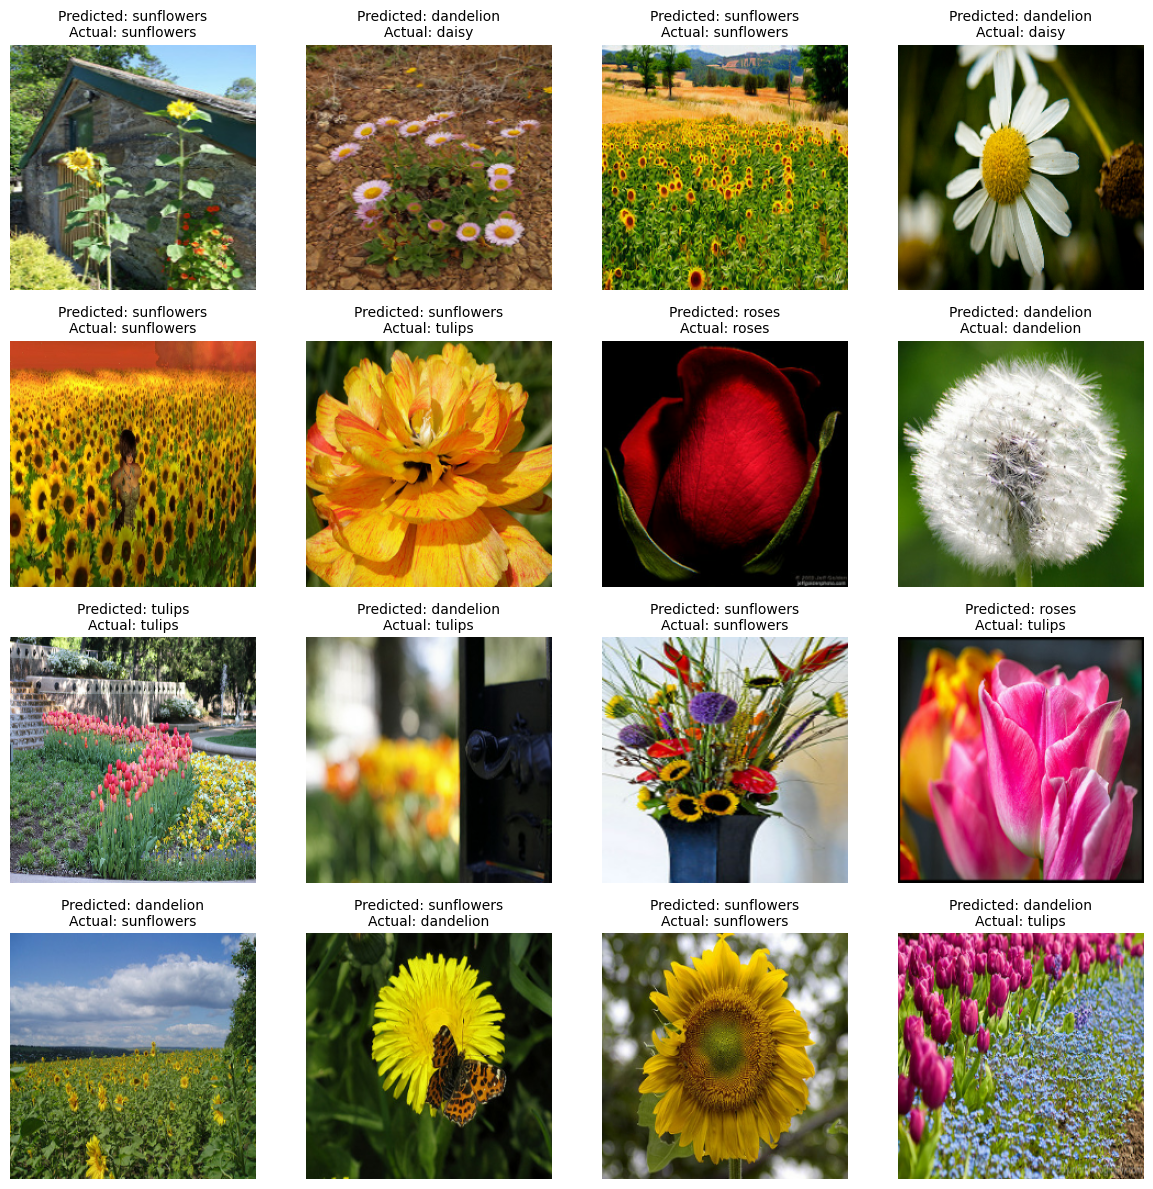

In [ ]:
import math

for images, labels in eval_dataset.take(1):
  batch_predictions = model.predict(images)
  predicted_indices = np.argmax(batch_predictions, axis = 1)

  num_images = images.shape[0]
  num_cols = 4
  num_rows = math.ceil(num_images / num_cols)

  plt.figure(figsize=(12,3*num_rows))

  for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(images[i].numpy())
    plt.axis("off")

    pred_class = CLASS_NAMES[predicted_indices[i]]
    actual_class = CLASS_NAMES[labels[i].numpy()]

    plt.title(f"Predicted: {pred_class}\nActual: {actual_class}", fontsize = 10)

  plt.tight_layout()
  plt.show